>

In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [2]:
# !pip install seaborn

In [3]:
Path_data = 'C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\'
data = os.listdir(Path_data)
Healthy = os.listdir('C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Healthy')
Mild = os.listdir('C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Mild DR')
Moderate = os.listdir('C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Moderate DR')
Proliferate = os.listdir('C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Proliferate DR')
Severe = os.listdir('C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Severe DR')

In [4]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



In [5]:
# Get Paths

Path_data = 'C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data 

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,C:\Users\piyus\Desktop\datasets_for_anjuman\DR...,Healthy
1,C:\Users\piyus\Desktop\datasets_for_anjuman\DR...,Healthy
2,C:\Users\piyus\Desktop\datasets_for_anjuman\DR...,Healthy
3,C:\Users\piyus\Desktop\datasets_for_anjuman\DR...,Healthy
4,C:\Users\piyus\Desktop\datasets_for_anjuman\DR...,Healthy


In [6]:
#X= Df.drop(['Labels'], axis = 1)
#y = Df['Labels']
#y.value_counts()

In [7]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy= 'not majority')#string
#ros = RandomOverSampler(sampling_strategy= 1) #Numerical value

#x_ros, y_ros= ros.fit_resample(X, y)

#ax = y_ros.value_counts().plot.pie(autopct='%.2f')
#_ = ax.set_title('over-sampling')

In [8]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           805
Moderate DR       723
Mild DR           291
Proliferate DR    230
Severe DR         151
Name: count, dtype: int64

In [9]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


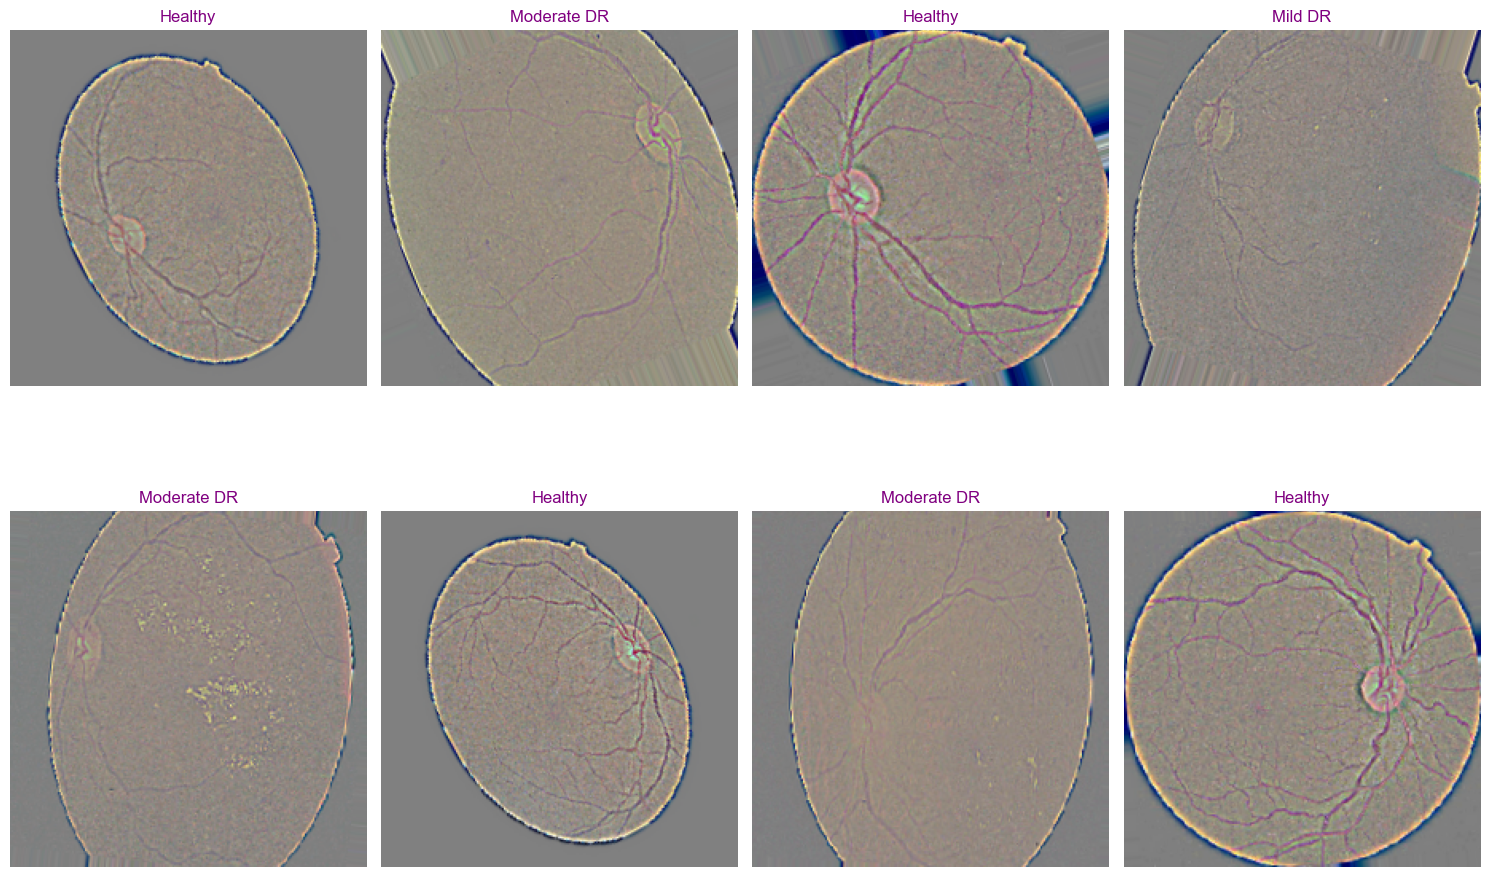

In [10]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

In [11]:
# Define number of classes 
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001)(x)
x = Dense(1024, 
          kernel_regularizer=regularizers.l2(0.01),  # Remove 'l=' parameter
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu')(x)
x = Dropout(rate=.2, seed=123)(x)
x = Dense(512,
          kernel_regularizer=regularizers.l2(0.01),  # Remove 'l=' parameter
          activity_regularizer=regularizers.l1(0.005),
          bias_regularizer=regularizers.l1(0.005),
          activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate



In [12]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [13]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [15]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [16]:
dot -V

NameError: name 'dot' is not defined

In [17]:
import os
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot

try:
    # Create visualizations directory if it doesn't exist
    os.makedirs('visualizations', exist_ok=True)
    
    # Plot the model
    
    plot_model(
        model,
        to_file='visualizations/convnet.png',
        show_shapes=True,
        show_layer_names=True,
        dpi=96
    )
    
    # Display the image
    Image(filename='visualizations/convnet.png')
    
except Exception as e:
    print(f"Error generating model visualization: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Ensure Graphviz is installed and in system PATH")
    print("2. Try restarting the Jupyter kernel")
    print("3. Check if the model is properly defined")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Error generating model visualization: [Errno 2] No such file or directory: 'visualizations/convnet.png'

Troubleshooting steps:
1. Ensure Graphviz is installed and in system PATH
2. Try restarting the Jupyter kernel
3. Check if the model is properly defined


## C- Training phase

In [19]:
epochs = 10
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - acc: 0.5877 - loss: 1.1520 - val_acc: 0.6291 - val_loss: 0.9686
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - acc: 0.6271 - loss: 1.0103 - val_acc: 0.6400 - val_loss: 0.9461
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - acc: 0.6213 - loss: 0.9663 - val_acc: 0.6618 - val_loss: 0.9222
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - acc: 0.6422 - loss: 0.9470 - val_acc: 0.6909 - val_loss: 0.8465
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - acc: 0.6698 - loss: 0.8603 - val_acc: 0.6909 - val_loss: 0.8425
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - acc: 0.6887 - loss: 0.8327 - val_acc: 0.6836 - val_loss: 0.8148
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - acc: 0.6859 - loss: 0.8275 - val_acc: 0.7055 - val_loss: 0.7977
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - acc: 0.7126 - loss: 0.7774 - val_acc: 0.6945 - val_loss: 0.8292
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/

## D- Evaluation 

In [28]:
model.save_weights('diabetic_model.weights.h5')  # Note the .weights.h5 extension

# Save complete model (alternative approach)
model.save('diabetic_model_complete.h5')

model.save("diabetic_model_reformatted.keras")


# Create visualizations directory if it doesn't exist
os.makedirs('model_files', exist_ok=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted class: Moderate


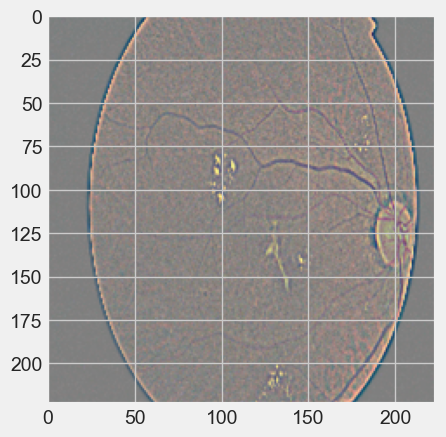

In [29]:
model.load_weights('diabetic_model_complete.h5')

from PIL import Image
prediction_datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30,
    fill_mode='nearest',
   
)
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Model expects a batch of images
    img = img / 255.0  # Normalize the image
    return img
    

# Function to preprocess and predict an image
def preprocess_and_predict(image_path, model):
    # Load the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image using the prediction ImageDataGenerator
    img_preprocessed = next(prediction_datagen.flow(img_array, batch_size=1))
    
    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_class = np.argmax(prediction, axis=1)
    
    return predicted_class, img


# Example usage
image_path = 'C:\\Users\\piyus\\Desktop\\datasets_for_anjuman\\DR\\Moderate DR\\Moderate_DR_111.png'  # Replace with your image path
predicted_class, predictions =preprocess_and_predict(image_path,model)

# Define the class names
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

import matplotlib.pyplot as plt
# Print the results

print(f"Predicted class: {class_names[predicted_class[0]]}")
plt.imshow(predictions)

In [25]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

    
# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

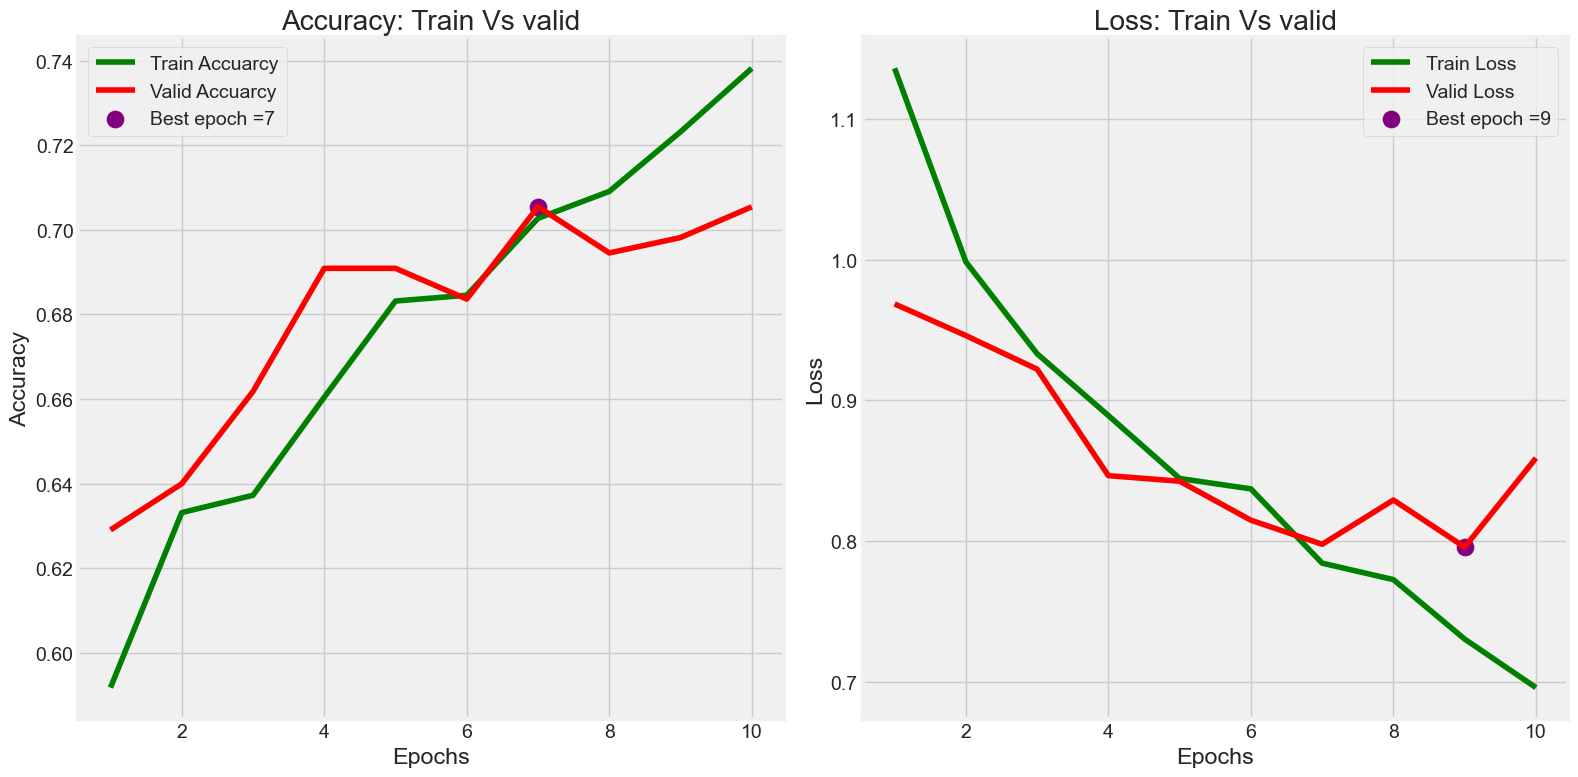

In [26]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

110/110 ━━━━━━━━━━━━━━━━━━━━ 54s 493ms/step - acc: 0.7885 - loss: 0.5575
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 434ms/step - acc: 0.7357 - loss: 0.7740
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 514ms/step - acc: 0.6605 - loss: 0.8807
Train Scores : 
    accuracy: 0.7913636565208435 
      Loss:  0.5583450794219971 
________________________
Valid Scores : 
    accuracy: 0.7054545283317566 
      Loss:  0.8589427471160889 
________________________
Test Scores : 
    accuracy: 0.6727272868156433 
      Loss:  0.9209358096122742 
________________________


# 5 Get  predictions

In [21]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[9.9999011e-01 9.8465707e-06 2.3693076e-08 1.1719375e-08 1.8426258e-09]
 [9.9995363e-01 4.6398192e-05 1.8223315e-10 2.5345618e-11 8.8258782e-11]
 [3.1950115e-04 2.7686843e-01 7.1854764e-01 2.7839611e-03 1.4805078e-03]
 ...
 [4.8190507e-04 9.4016111e-01 1.6542938e-02 4.1313417e-02 1.5006153e-03]
 [9.9999034e-01 9.7037846e-06 3.0840603e-08 5.9113807e-09 8.8931795e-09]
 [1.0598548e-07 5.2438082e-07 9.9999762e-01 1.2870349e-07 1.7165851e-06]]
[0 0 2 1 1 0 2 1 0 1 3 0 0 2 1 1 1 1 1 0 0 0 0 2 3 1 1 2 1 2 2 0 0 3 0 1 1
 2 2 2 0 3 2 1 2 1 0 2 0 1 1 1 2 3 1 0 2 0 4 2 0 2 1 2 0 2 0 0 0 2 0 2 0 0
 3 2 1 1 0 0 2 1 2 2 0 1 0 3 1 1 2 1 2 1 0 3 2 3 1 2 1 1 4 3 0 0 0 3 0 2 4
 0 3 4 0 2 0 4 2 1 0 3 0 1 1 3 1 0 0 2 0 1 0 2 3 1 1 0 2 1 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 1 0 0 2 1 2 2 0 2 2 1 4 0 0 1 0 2 0 4 2 1 3 0 0 0 2 2 1 2 3 0
 2 0 2 2 1 1 0 2 0 0 3 2 2 1 1 3 1 0 2 0 4 1 3 2 0 2 0 2 2 0 0 1 0 1 0 2 2
 2 2 2 3 4 2 4 0 2 0 0 0 0 3 0 0 0 2 0 0 2 2 0 3 0 0 1 0 0 1 4 1 0 0 0 0 1
 2 3 1 2 4 2 1 1 4 0 0 1 2 1 0 

In [22]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[97,  2,  0,  0,  0],
       [ 5, 38,  3,  0,  0],
       [ 0, 18, 57,  9,  6],
       [ 0,  3,  7, 12,  0],
       [ 1,  2,  4,  4,  7]])

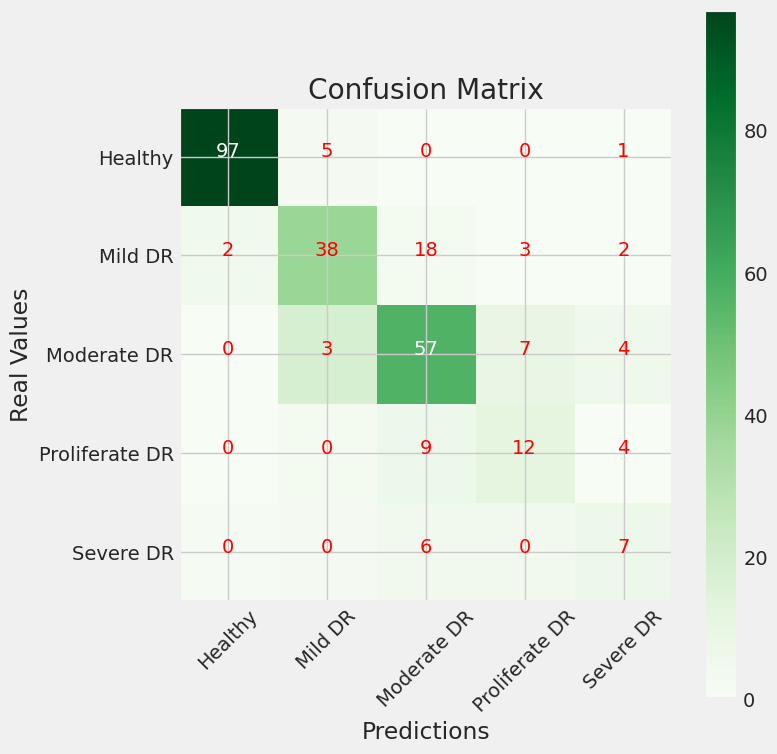

In [23]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [24]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


                precision    recall  f1-score   support

       Healthy       0.94      0.98      0.96        99
       Mild DR       0.60      0.83      0.70        46
   Moderate DR       0.80      0.63      0.71        90
Proliferate DR       0.48      0.55      0.51        22
     Severe DR       0.54      0.39      0.45        18

      accuracy                           0.77       275
     macro avg       0.67      0.67      0.67       275
  weighted avg       0.78      0.77      0.76       275



# 7 Save model

In [25]:
model.save('effB3 CNN DR.h5')

#### If you found it useful...please upvote it!

#### Thank you